In [1]:
import os
# os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin") // path to nvidia dlls, must have CUDA drivers installed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

### GPU Acceleration

** IMPORTANT NOTE **
 - You must have CUDA driver and CUDA toolkit installed on your machine. To do so, follow the instructions here:
https://www.tensorflow.org/install/pip

- Enable GPU Acceleration if you have a NVIDIA GPU with compute capability >= 7.0

In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# ## ENABLE THIS IF YOU HAVE RTX GPU WITH COMPUTE CAPABILITY 7.0 or higher
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

### Loading Data

In [3]:
fp = "../data/features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset.sort_values(by=['policy'], ascending=True, inplace=True)

# dataset
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])

### Test run setup
1. Adjust global model config to test the model settings
2. Change the Run configuration to define the saved location for the results and the number of runs
3. Run the notebook
4. Clear output and restart the notebook for the next run.

In [4]:
## Global Model Config
EPOCHS = 2500 # number of epochs to train the model
UNITS = 1 # number of hidden units in the model
LEARNING_RATE = 0.01 # learning rate for the model
CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='RMSE', patience=15, min_delta=0.1)

#### Run configuration

In [5]:
## Define the run setup

RUN_NUMBER = 1 # Test run nubmer
SAVED_RESULT_PATH = "../variance_model/results/test_run#" + str(RUN_NUMBER) # path to saved results

if ( os.path.exists(SAVED_RESULT_PATH) ):
    print("Directory " , SAVED_RESULT_PATH , " already exists")
else:
    os.mkdir(SAVED_RESULT_PATH)
    print("Directory " , SAVED_RESULT_PATH , " created")

Directory  ../variance_model/results/64u_test_run#2  already exists


## Data split
Split by policy fast charge first(5C - 8C), and then by policy slow charge (1C - 4C)


In [6]:
normal_charge_dataset = dataset.iloc[0:29, :] # 29 data points
print(normal_charge_dataset.shape)

(29, 15)


## Normal-Charge Test-Train split
Selecting alternate batteries for training and testing

In [7]:
normal_charge_train_ds = normal_charge_dataset.iloc[0::2, :]
normal_charge_test_ds = normal_charge_dataset.iloc[1::2, :]

normalcharge_train_features = normal_charge_train_ds.copy()
normalcharge_test_features = normal_charge_test_ds.copy()

normal_train_labels = normalcharge_train_features.pop('cycle_life')
normal_test_labels = normalcharge_test_features.pop('cycle_life')

## Loading Pretrained model (fastcharge basemodel)

In [8]:
fastcharge_basemodel = tf.keras.models.load_model("../variance_model/saved_model/variance_fastcharge_basemodel")
normalcharge_transfermodel = fastcharge_basemodel
normalcharge_transfermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 196
Trainable params: 193
Non-trainable params: 3
_________________________________________________________________


### Layer freezing

In [9]:
## Freezing every layer except the last layer
for layer in normalcharge_transfermodel.layers[:-1]:
  layer.trainable = False

normalcharge_transfermodel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[ 
        tf.keras.metrics.RootMeanSquaredError( name='RMSE'), 
        'mae']
    )

normalcharge_transfermodel.summary()
print("Number of weights weights:", len(normalcharge_transfermodel.weights))
print("trainable_weights:", len(normalcharge_transfermodel.trainable_weights))
print("non_trainable_weights:", len(normalcharge_transfermodel.non_trainable_weights))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 196
Trainable params: 65
Non-trainable params: 131
_________________________________________________________________
Number of weights weights: 7
trainable_weights: 2
non_trainable_weights: 5


### Train the Model

In [10]:
%%time
history = normalcharge_transfermodel.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[CALLBACK], #apply a early stopping callback
    validation_data=(normalcharge_test_features['QDiffLinVar'], normal_test_labels))

Epoch 1/2500
1/1 - 1s - loss: 171685.8906 - RMSE: 414.3500 - mae: 258.1522 - val_loss: 175449.5938 - val_RMSE: 418.8670 - val_mae: 255.2481 - 568ms/epoch - 568ms/step
Epoch 2/2500
1/1 - 0s - loss: 169878.3906 - RMSE: 412.1631 - mae: 256.6869 - val_loss: 173824.6406 - val_RMSE: 416.9228 - val_mae: 253.4214 - 26ms/epoch - 26ms/step
Epoch 3/2500
1/1 - 0s - loss: 168084.1406 - RMSE: 409.9807 - mae: 255.2221 - val_loss: 172210.6719 - val_RMSE: 414.9827 - val_mae: 251.5954 - 26ms/epoch - 26ms/step
Epoch 4/2500
1/1 - 0s - loss: 166303.4062 - RMSE: 407.8032 - mae: 253.7577 - val_loss: 170607.7969 - val_RMSE: 413.0470 - val_mae: 249.7702 - 28ms/epoch - 28ms/step
Epoch 5/2500
1/1 - 0s - loss: 164536.4219 - RMSE: 405.6309 - mae: 252.2941 - val_loss: 169016.4219 - val_RMSE: 411.1161 - val_mae: 247.9464 - 31ms/epoch - 31ms/step
Epoch 6/2500
1/1 - 0s - loss: 162783.2969 - RMSE: 403.4641 - mae: 250.8314 - val_loss: 167436.6094 - val_RMSE: 409.1902 - val_mae: 246.1240 - 25ms/epoch - 25ms/step
Epoch 7/

### Plot loss graph and Evaluate

In [11]:
## Load basemodel history for plotting comparision
normalcharge_basemodel_history_path = SAVED_RESULT_PATH + "/normalcharge_basemodel_history_RUN#" + str(RUN_NUMBER) + ".csv"
basemodel_history = pd.read_csv(normalcharge_basemodel_history_path)

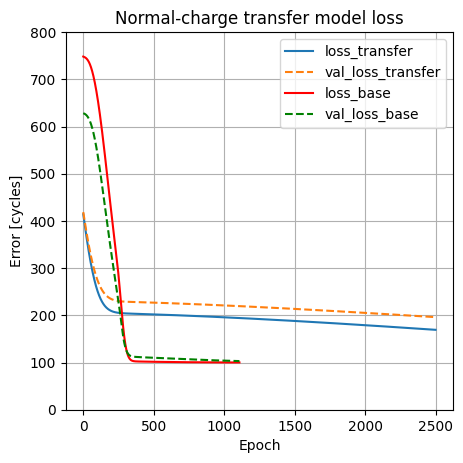

In [12]:
def plot_loss(transfermode_hist, basemodel_hist):
  plt.figure("Normal-charge transfer model loss", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.plot(transfermode_hist['RMSE'], label='loss_transfer')
  plt.plot(transfermode_hist['val_RMSE'], label='val_loss_transfer', linestyle='dashed')
  plt.plot(basemodel_hist['RMSE'], label='loss_base', color='red', )
  plt.plot(basemodel_hist['val_RMSE'], label='val_loss_base', color='green', linestyle='dashed')
  plt.ylim([0, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)
  plt.title('Normal-charge transfer model loss')
  plt.savefig(SAVED_RESULT_PATH + "/normalcharge_transfermodel_loss_RUN#" + str(RUN_NUMBER) + ".png")

## Display model's loss and accuracy history
transfermodel_history = pd.DataFrame(history.history)
transfermodel_history

plot_loss(transfermodel_history, basemodel_history)

In [13]:
## Display model's loss and accuracy history
transfermodel_history = pd.DataFrame(history.history)
transfermodel_history.to_csv(SAVED_RESULT_PATH + "/normalcharge_transfermodel_history_RUN#" + str(RUN_NUMBER) + ".csv")
transfermodel_history

,loss,RMSE,mae,val_loss,val_RMSE,val_mae
0,171685.890625,414.349976,258.152161,175449.593750,418.867035,255.248123
1,169878.390625,412.163055,256.686920,173824.640625,416.922821,253.421371
2,168084.140625,409.980652,255.222061,172210.671875,414.982727,251.595352
3,166303.406250,407.803162,253.757721,170607.796875,413.046967,249.770187
4,164536.421875,405.630890,252.294113,169016.421875,411.116058,247.946365
...,...,...,...,...,...,...
2495,28699.093750,169.408066,124.369484,38521.511719,196.268982,138.215347
2496,28692.232422,169.387817,124.357765,38514.210938,196.250381,138.201813
2497,28685.371094,169.367569,124.346031,38506.902344,196.231750,138.188278
2498,28678.521484,169.347336,124.334297,38499.585938,196.213120,138.174744


In [14]:
test_results = {}
test_results['variance_normalcharge_transfermodel'] = normalcharge_transfermodel.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 21ms/step - loss: 38492.2773 - RMSE: 196.1945 - mae: 138.1612


### Make Predictions

1/1 [==============================] - 0s 18ms/step


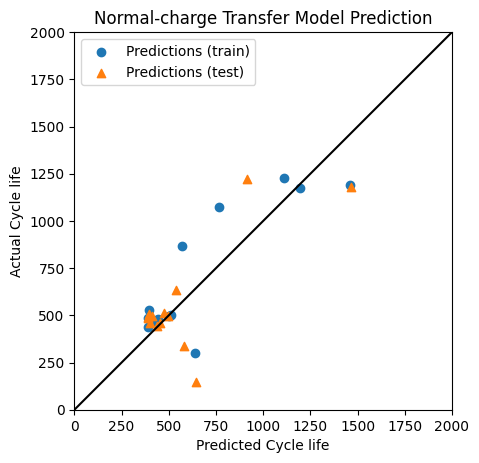

In [15]:
def plot_prediction(y_train, y_test):
  plt.figure("Normal-charge transfer model loss", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, normal_train_labels, label='Predictions (train)')
  plt.scatter(y_test, normal_test_labels, label='Predictions (test)', marker='^')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()
  plt.title('Normal-charge Transfer Model Prediction')
  plt.savefig( SAVED_RESULT_PATH + '/normalcharge_transfermodel_prediction_RUN#' + str(RUN_NUMBER) + ".png")

normal_train_prediction = normalcharge_transfermodel.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction = normalcharge_transfermodel.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction, normal_test_prediction)

### Final Results

In [16]:
result = pd.DataFrame(test_results, index=['MSE', 'RMSE', 'MAE']).T
result.to_csv( SAVED_RESULT_PATH + '/normalcharge_transfermodel_result_RUN#' + str(RUN_NUMBER) + ".csv")

### Saving the model

In [17]:
normalcharge_transfermodel.save('../variance_model/saved_model/variance_normalcharge_transfermodel')

INFO:tensorflow:Assets written to: ../variance_model/saved_model/variance_normalcharge_transfermodel\assets
